Дисциплина: Методы и технологии машинного обучения

Уровень подготовки: бакалавриат

Направление подготовки: 01.03.02 Прикладная математика и информатика

Семестр: осень 2022/2023

# Лабораторная работа №4: Методы снижения размерности. Регуляризация логистической регрессии.
### Кузема София Евгеньевна
### Вариант 13






## Загружаем пакеты

In [1]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  стандартизация показателей
from sklearn.preprocessing import StandardScaler
#  метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
#  логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#  перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
#  расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# константы
#  ядро для генератора случайных чисел
my_seed = 13
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
sns.color_palette("Set2")

C:\Users\Ирина\AppData\Local\Temp\ipykernel_18004\650184880.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-whitegrid')


[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [3]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
#  из репозитория к книге С.Рашки Python и машинное обучение,
#  слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
                        C_min_pow=-4, C_max_pow=3.) :
    fig = plt.figure()
    ax = plt.subplot(111)    
    
    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)
    
    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name, 
                                C=10.**c, solver='liblinear', 
                                multi_class='ovr', random_state=my_seed)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)

    weights = np.array(weights)

    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column],
                 label=col_names[column],
                 color=color)

    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta', 
                linestyle='--', linewidth=1)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', 
              bbox_to_anchor=(1.38, 1.03),
              ncol=1, fancybox=True)
    plt.show()

## Загружаем данные

Загружаем данные
Набор данных default_of_credit_card_clients в формате .csv доступен для загрузки по адресу: https://raw.githubusercontent.com/ania607/ML/main/data/default_of_credit_card_clients.csv.

Загружаем данные во фрейм и выясняем их размерность.

In [21]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/default_of_credit_card_clients.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


In [22]:
DF_raw.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Отложим 15% наблюдений для прогноза.  

In [23]:
# наблюдения для моделирования
DF = DF_raw.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_raw.drop(DF.index)

In [24]:
# типы столбцов фрейма
DF.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Y            int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [25]:
# считаем пропуски в каждом столбце
DF.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Y            0
dtype: int64

Пропусков не обнаружено.  

# Предварительный анализ данных  

## Описательные статистики  

Считаем доли классов целевой переменной `Y`.  

In [26]:
# метки классов
DF.Y.unique()

array([0, 1], dtype=int64)

In [28]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

0    0.781
1    0.219
Name: Y, dtype: float64

In [83]:
# описательные статистики
DF.iloc[:, :8].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000
mean,167848.614902,1.604510,1.854078,1.551137,35.473647,-0.019294,-0.136745,-0.171020
std,129894.926164,0.488965,0.791689,0.521709,9.224644,1.125633,1.197933,1.193489
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000
max,800000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000


In [84]:
# описательные статистики
DF.iloc[:, 8:16].describe()

,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,2.550000e+04,25500.000000,25500.000000
mean,-0.226353,-0.272706,-0.295529,51145.782353,49093.645412,4.689561e+04,43011.959020,40047.777804
std,1.167079,1.131698,1.151099,73030.089201,70556.209422,6.893268e+04,63681.324672,60026.412733
min,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-6.150600e+04,-170000.000000,-81334.000000
25%,-1.000000,-1.000000,-1.000000,3578.000000,2956.500000,2.635000e+03,2280.000000,1740.750000
50%,0.000000,0.000000,0.000000,22344.500000,21224.000000,2.003500e+04,19010.000000,18067.000000
75%,0.000000,0.000000,0.000000,67573.250000,64367.000000,6.031300e+04,54429.500000,50065.250000
max,8.000000,8.000000,8.000000,653062.000000,671563.000000,1.664089e+06,706864.000000,587067.000000


In [85]:
# описательные статистики
DF.iloc[:, 16:23].describe()

,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,25500.000000,25500.000000,2.550000e+04,25500.000000,25500.000000,25500.000000,25500.000000
mean,38657.944118,5721.081059,5.912399e+03,5195.790706,4851.610588,4847.703137,5248.818863
std,59003.614301,16819.669309,2.259416e+04,16745.180224,15980.476266,15559.835697,17901.580110
min,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1242.000000,1000.000000,8.360000e+02,390.000000,298.750000,243.750000,108.750000
50%,17001.500000,2111.500000,2.010000e+03,1826.500000,1500.000000,1500.000000,1500.000000
75%,49162.750000,5015.000000,5.000000e+03,4512.750000,4027.000000,4064.250000,4000.000000
max,699944.000000,873552.000000,1.684259e+06,889043.000000,621000.000000,426529.000000,528666.000000


Выводы по описательным статистикам: не все значения объясняющих переменных положительные, масштабы измерения отличаются. Для работы с методами снижения размерности и регуляризации понадобится стандартизация значений.

## Визуализация разброса переменных внутри классов  

Поскольку в наборе данных 23 объясняющих переменных, и все они непрерывные, анализ матричного графика разброса будет затруднительным. Построим коробчатые диаграммы для объясняющих переменных, чтобы сравнить средние уровни и разброс по классам.  

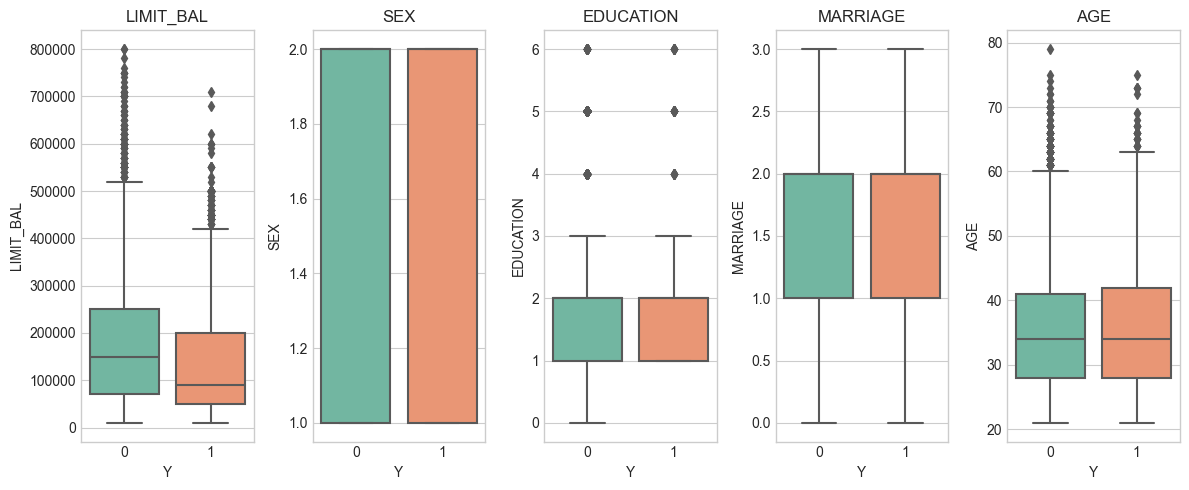

In [31]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[:5].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

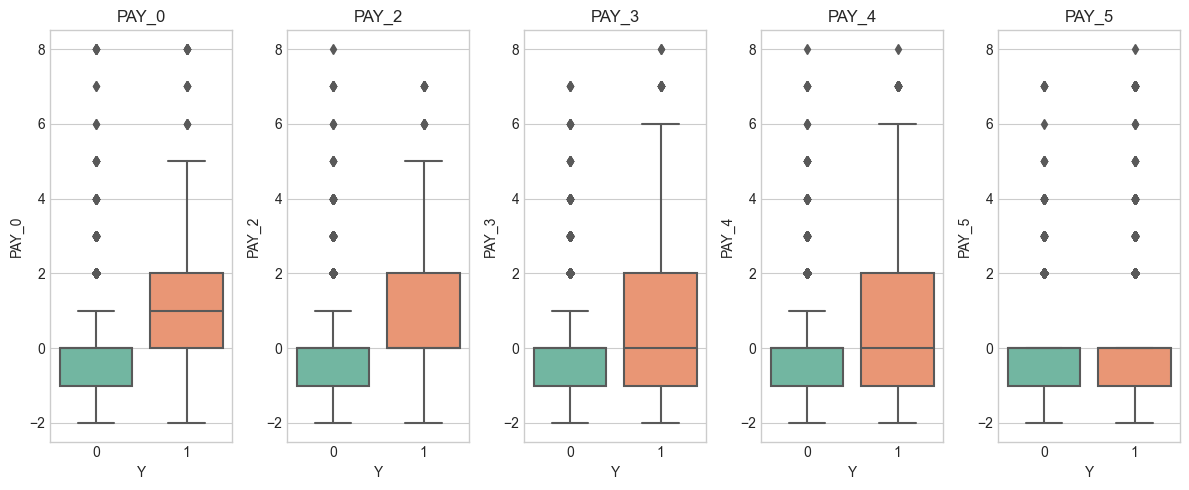

In [33]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[5:10].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

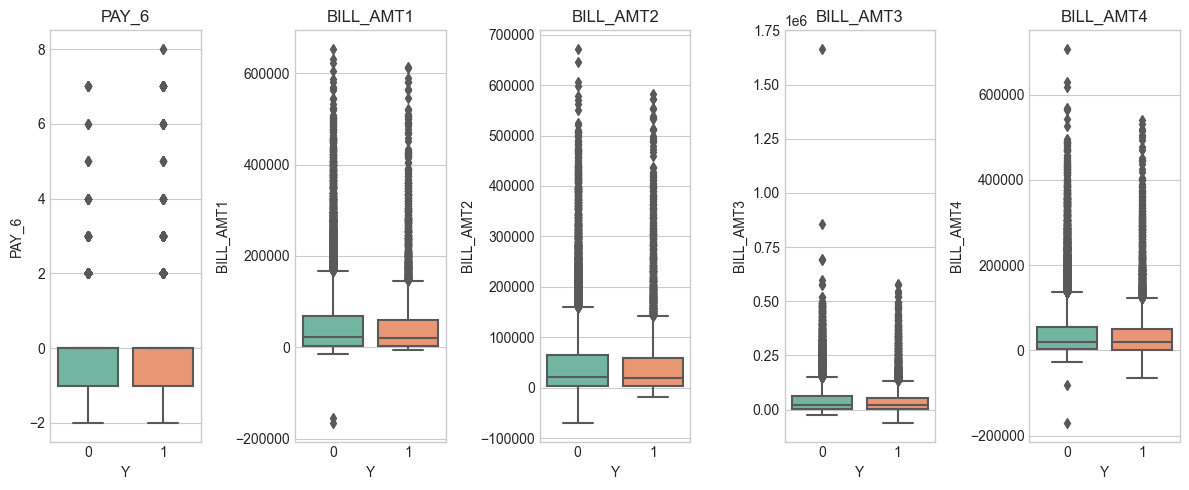

In [34]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[10:15].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

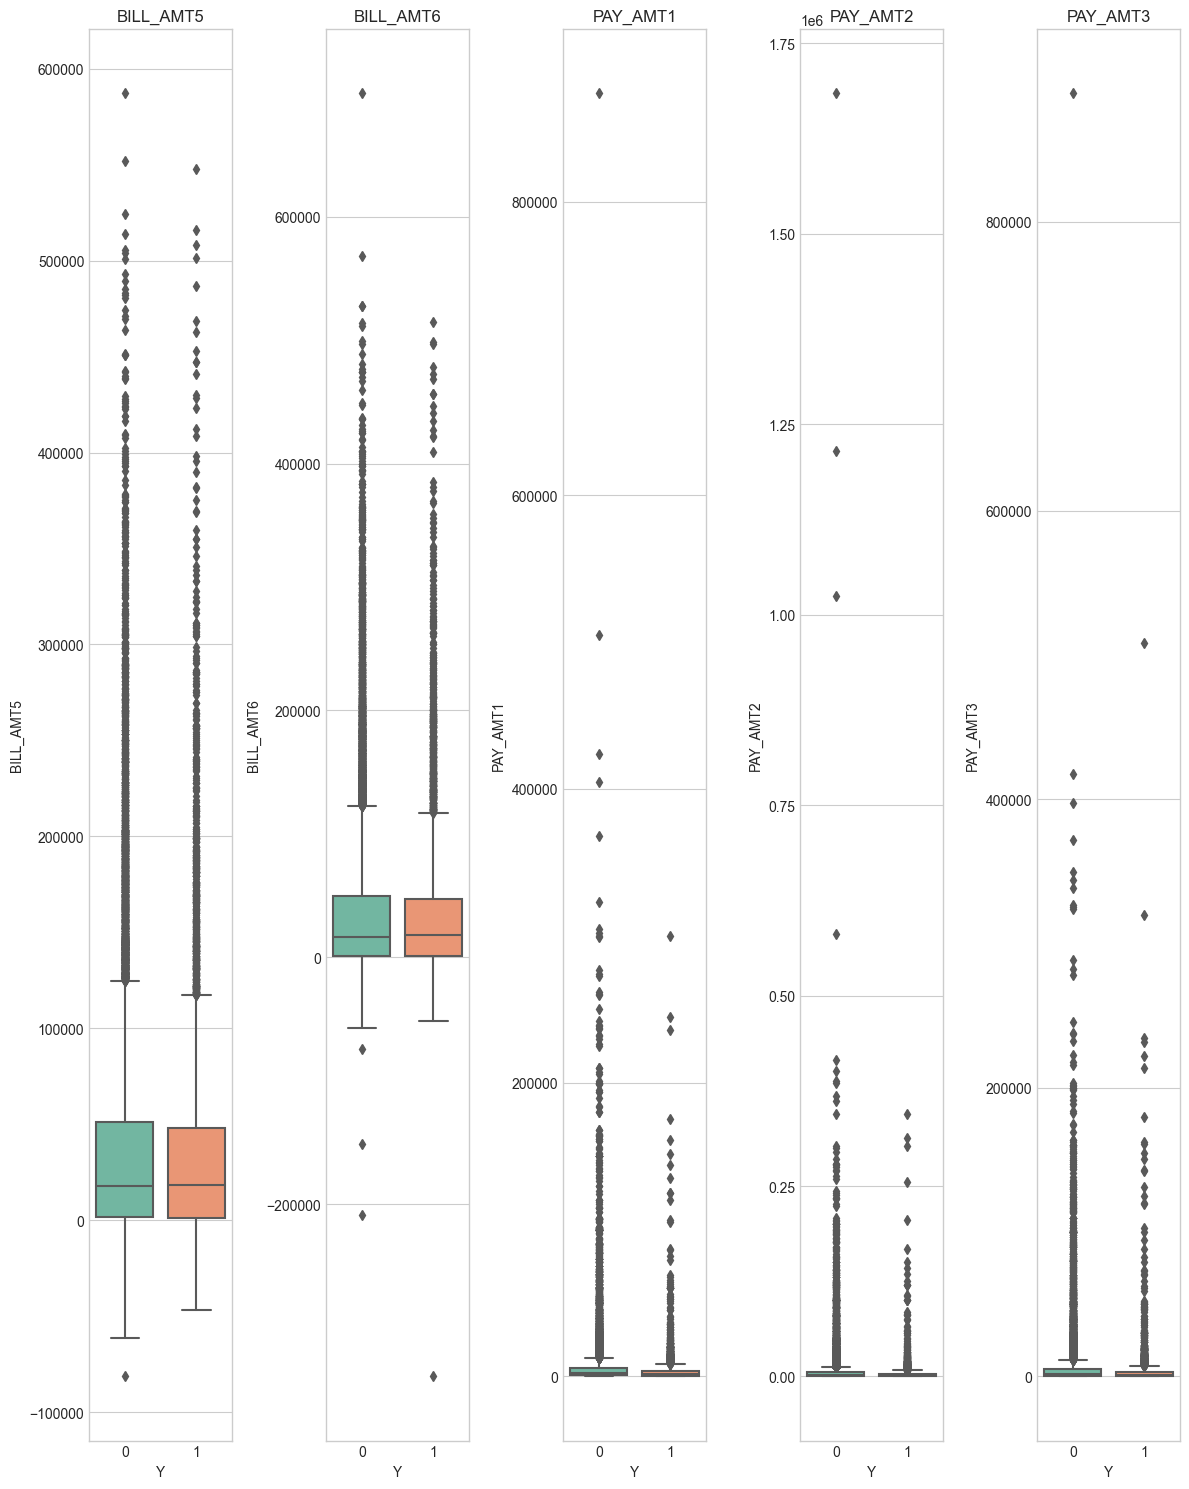

In [45]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 15))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[15:20].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

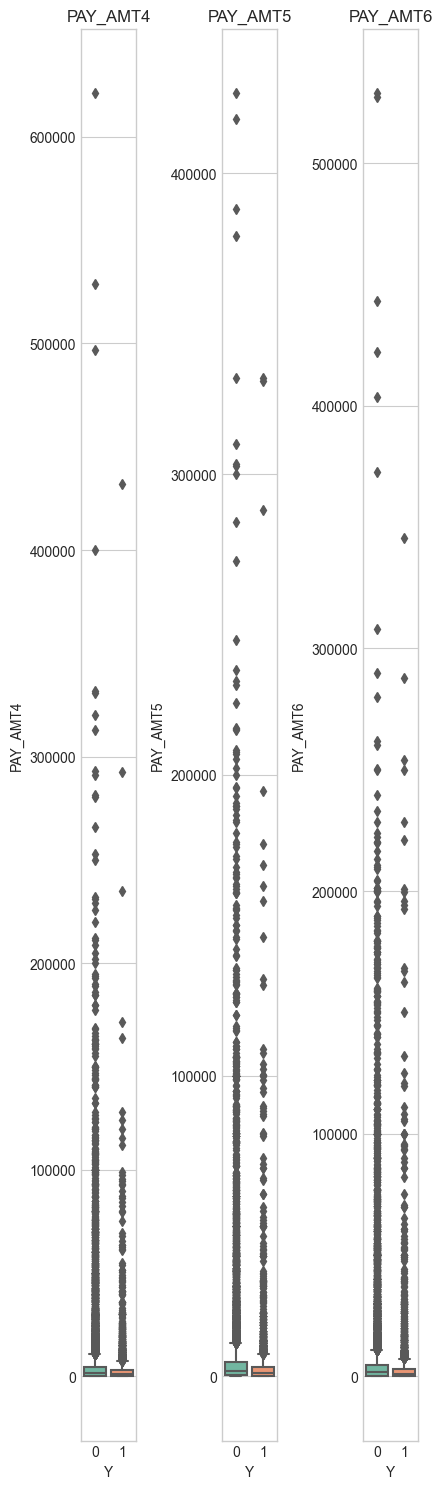

In [42]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(7.2, 15))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])


axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[20:23].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

На графиках отличие в медианах и разбросе между классами незначтельны для переменных "LIMIT_BAL", "SEX","EDUCATION","MARRIAGE","AGE". По верхнему, нижнему квартилю и медиане больше всего различаются коробчатые диаграммы по переменным 'PAY_0','PAY_2','PAY_3','PAY_4'. А по разбросу значений переменный с большим количеством аномальных значений: "PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6". Это говорит о том, классы по зависимой переменной 'Y' плохо разделяются по многим переменным.  

## Корреляционный анализ   

Теперь посмотрим на взаимодействие объясняющих переменных.  

C:\Users\Ирина\AppData\Local\Temp\ipykernel_18004\3219125578.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-white')


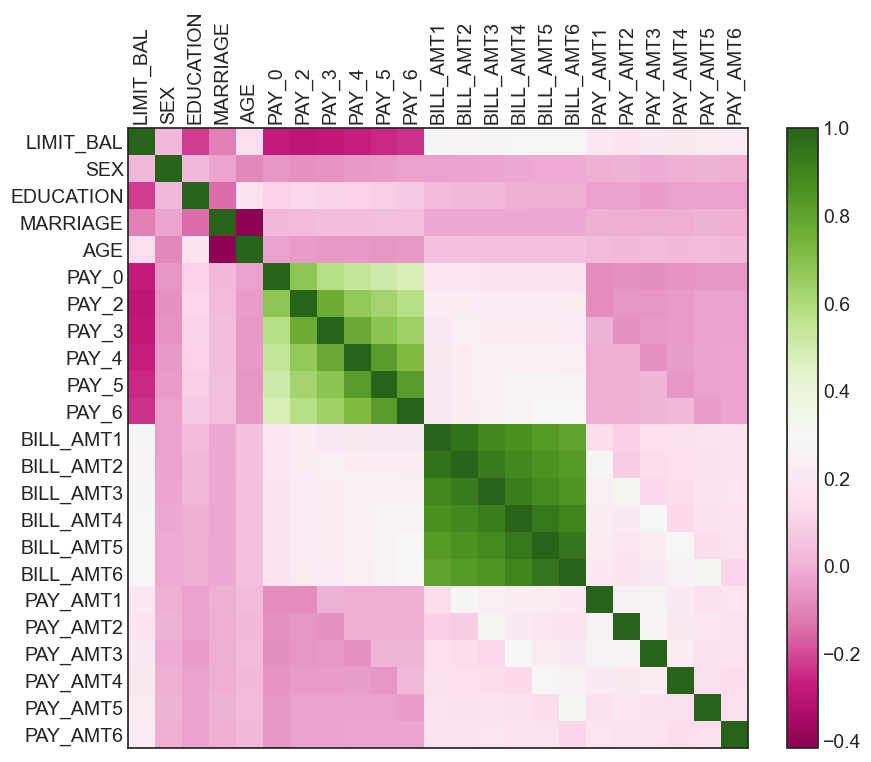

In [47]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns

# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')

# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

Между объясняющими переменными обнаруживаются как прямые, так и обратные линейные взаимосвязи. Выведем все значимые коэффициенты в одной таблице и определим минимальный / максимальный из них.     

In [86]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
#  и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
#  корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция ** 2))
df['P_значение'] = 2 * (1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
#  выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
107,5,13,-5.185860e-15,0.0
32,1,12,-3.328664e-15,0.0
90,4,13,-2.892480e-15,0.0
0,0,1,-2.144707e-15,0.0
26,1,6,-1.328195e-15,0.0
...,...,...,...,...
24,1,4,2.033009e-15,0.0
123,6,13,2.218778e-15,0.0
106,5,12,2.920756e-15,0.0
25,1,5,5.055432e-15,0.0


# Метод снижения резмерности  

In [52]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, :23].values)

# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
    print('Столбец ', i_col, ': среднее = ',
          np.round(np.mean(X_train_std[:, i_col]), 2),
         '   Станд. отклонение = ', 
          np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = -0.0   Станд. отклонение = 1.0
Столбец 1: среднее = 0.0   Станд. отклонение = 1.0
Столбец 2: среднее = -0.0   Станд. отклонение = 1.0
Столбец 3: среднее = -0.0   Станд. отклонение = 1.0
Столбец 4: среднее = -0.0   Станд. отклонение = 1.0
Столбец 5: среднее = -0.0   Станд. отклонение = 1.0
Столбец 6: среднее = 0.0   Станд. отклонение = 1.0
Столбец 7: среднее = -0.0   Станд. отклонение = 1.0
Столбец 8: среднее = 0.0   Станд. отклонение = 1.0
Столбец 9: среднее = -0.0   Станд. отклонение = 1.0
Столбец 10: среднее = 0.0   Станд. отклонение = 1.0
Столбец 11: среднее = 0.0   Станд. отклонение = 1.0
Столбец 12: среднее = -0.0   Станд. отклонение = 1.0
Столбец 13: среднее = 0.0   Станд. отклонение = 1.0
Столбец 14: среднее = 0.0   Станд. отклонение = 1.0
Столбец 15: среднее = -0.0   Станд. отклонение = 1.0
Столбец 16: среднее = 0.0   Станд. отклонение = 1.0
Столбец 17: среднее = 0.0   Станд. отклонение = 1.0
Столбец 18: среднее = 0.0   Станд. отклонение = 1.0
Столбец 19: с

## Регрессия на главные компоненты (PCR)  

Пересчитаем объясняющие показатели в главные компоненты.  

In [53]:
# функция с методом главных компонент
pca = PCA()
# пересчитываем в главные компоненты (ГК)
X_train_pca = pca.fit_transform(X_train_std)

# считаем доли объяснённой дисперсии
frac_var_expl = pca.explained_variance_ratio_
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
     np.around(frac_var_expl, 3),
     '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.283 0.178 0.068 0.064 0.045 0.041 0.04  0.039 0.037 0.033 0.033 0.03
 0.025 0.023 0.017 0.011 0.011 0.008 0.006 0.003 0.002 0.001 0.001] 
Общая сумма долей: 1.0


Главные компоненты взаимно ортогональны, убедимся в этом.  

In [54]:
# ГК ортогональны – убедимся в этом, рассчитыв корреляционную матрицу
corr_mat = pd.DataFrame(X_train_pca).corr()
np.around(corr_mat, 2)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,...,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0
1,-0.0,1.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,...,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0
2,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
3,0.0,-0.0,-0.0,1.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,...,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0
4,0.0,0.0,-0.0,0.0,1.0,0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0
5,0.0,0.0,-0.0,0.0,0.0,1.0,-0.0,0.0,-0.0,0.0,...,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0
6,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0
7,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,1.0,0.0,-0.0,...,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
8,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0,-0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
9,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,1.0,...,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0


Построим график объяснённой дисперсии. 

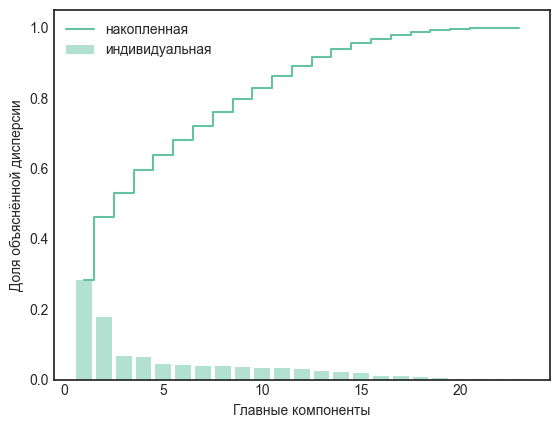

In [55]:
# график объяснённой дисперсии
plt.bar(range(1, 24), pca.explained_variance_ratio_, alpha=0.5, 
        align='center', label='индивидуальная')
plt.step(range(1, 24), np.cumsum(pca.explained_variance_ratio_), 
         where='mid', label='накопленная')
plt.ylabel('Доля объяснённой дисперсии')
plt.xlabel('Главные компоненты')
plt.legend()
plt.show()

Столбцы на графике показывают долю исходной дисперсии исходных переменных, которую объясняет главная компонента. Линией показана накопленная доля. Так, видно, что первые 4 компоненты объясняют 60% исходной дисперсии $X$.   
Чтобы увидеть, как классы выглядят в координатах ГК на графике, придётся сократить пространство для двух компонент, которые объясняют 46,1% разброса объясняющих переменных. 

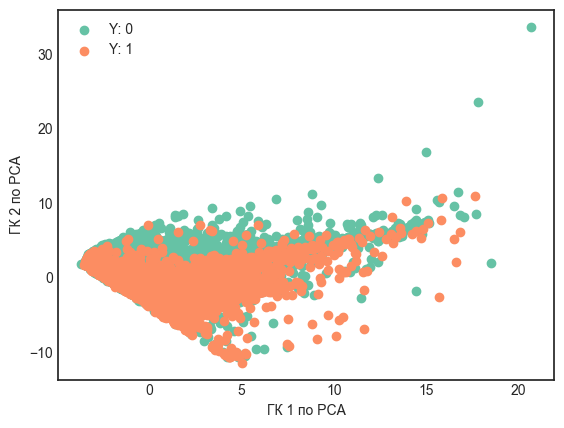

In [57]:
# пересчитываем X в 2 ГК
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)

# график классов в пространстве ГК
plt.scatter(X_train_pca[DF['Y'] == 0][:, 0], 
            X_train_pca[DF['Y'] == 0][:, 1], label='Y: 0')
plt.scatter(X_train_pca[DF['Y'] == 1][:, 0], 
            X_train_pca[DF['Y'] == 1][:, 1], label='Y: 1')
plt.xlabel('ГК 1 по PCA')
plt.ylabel('ГК 2 по PCA')
plt.legend()
plt.show()

Судя по графику, классы плохо разделяются в пространстве двух главных компонент. Построим логистическую регрессию и оценим её точность с помощью перекрёстной проверки

In [75]:
# функция оценки логистической регрессии
logit = LogisticRegression()
# функция разбиения на блоки для перекрёстной проверки
kf_10 = KFold(n_splits=10, random_state=my_seed, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
score = list()
acc = cross_val_score(logit, X_train_pca, DF.Y.values, cv=kf_10,
                     scoring='accuracy').mean()
score.append(np.around(acc, 3))
score_models = list()
score_models.append('logit_PC2')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', np.around(score[0], 2), sep='')

Модель logit_PC2, перекрёстная проверка по 10 блокам
Acc = 0.8


# Методы сжатия  

## Ридж-регрессия  

Функция `LogisticRegression()` умеет работать с мультиклассовой классификацией, используя при оценке параметров подход **один класс против остальных**. Построим ридж на наших данных.  

In [76]:
# значения Y как метки классов
Y_train = DF.Y.values
# значения Y как фиктивные переменные
Y_train_dummy = pd.get_dummies(Y_train.astype(str))
# оцениваем
pca.fit(X_train_std, Y_train)
# функция для построения модели
logit_ridge = LogisticRegression(penalty='l2', solver='liblinear')
# оцениваем параметры
logit_ridge.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_ridge.intercept_, 3),
     '\nКоэффициенты моделей для классов:\n', np.around(logit_ridge.coef_, 3))

Константы моделей для классов:
 [-1.477] 
Коэффициенты моделей для классов:
 [[-0.103 -0.056 -0.078 -0.072  0.077  0.64   0.112  0.077  0.028  0.041
   0.006 -0.419  0.222  0.08  -0.036  0.024  0.032 -0.217 -0.21  -0.043
  -0.072 -0.05  -0.032]]


Подбираем гиперпараметр регуляризации $\lambda$ с помощью перекрёстной проверки. В функции 
`LogisticRegression()` есть аргумент $C$ – это инверсия гиперпараметра $\lambda$.   

In [77]:
# поиск оптимального значения C:
#  подбираем C по наибольшей точности с перекрёстной проверкой
ridge_cv = LogisticRegressionCV(cv=10, random_state=my_seed+2, 
                                penalty='l2', solver='liblinear')
ridge_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
#  точность для каждого класса
ridge_cv.C_

array([21.5443469])

In [78]:
# сохраняем и выводим Acc для модели
score.append(np.around(ridge_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_ridge')
print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', score[1], sep='')

Модель logit_ridge, перекрёстная проверка по 10 блокам
Acc = 0.812


Изобразим изменение коэффициентов ридж-регрессии на графике и сделаем отсечку на уровне оптимального параметра $C$.  

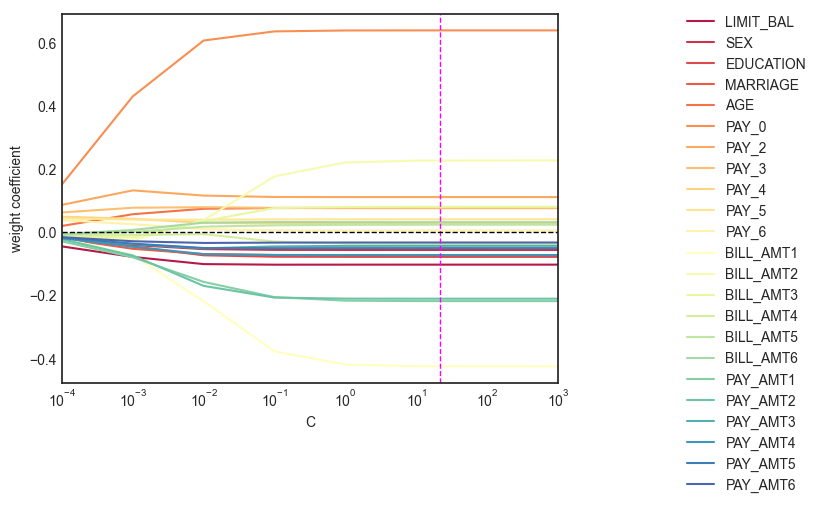

In [79]:
# график динамики коэффициентов в ридж-регрессии    
#  модель для класса 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l2', ridge_cv.C_, DF.columns)

Итак, судя по графикам, для значения гиперпараметра, дающего самую точную модель, некоторые коэффициенты при объясняющих переменных обнуляются. Это подтверждает наблюдение, сделанное нами ещё на этапе предварительного анализа: некоторые переменные плохо разделяют классы. Также можно наблюдать, что при С>10^0,5 (приблизительное значение) весовые коэффициенты объясняющих переменных равны константе.

# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [80]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,logit_PC2,0.798
1,logit_ridge,0.812


Все модели показывают высокую точность по показателю $Acc$, при этом самой точной оказывается ридж-регрессия. Сделаем прогноз на отложенные наблюдения. 

In [81]:
# формируем объекты с данными отложенной выборки
X_pred_std = sc.fit_transform(DF_predict.iloc[:, :23].values)
Y_pred = DF_predict.Y
Y_hat = logit_ridge.predict(X_pred_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      3454
           1       0.71      0.22      0.34      1046

    accuracy                           0.80      4500
   macro avg       0.76      0.60      0.61      4500
weighted avg       0.78      0.80      0.75      4500



Итак, методом логистической регрессии со сжатием коэффициенты с L2-регуляризацией мы получили достаточно точную модель для класса 0 (f1-score=0,88) и достаточно низкую для класса 1 (f1-score=0,34). Это говорит о том, что объясняющую переменную "Y" не стоит испльзовать для прогноза на данной выборке.  

# Источники 

1. *Рашка С.* Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.  
1. Репозиторий с кодом к книге *Рашка С.* Python и машинное обучение / github.com. URL: <https://github.com/rasbt/python-machine-learning-book-3rd-edition>  
1. *Xueting Bai*, *Lingbo Wang*, *Hanning Li* Identification of red wine categories based on physicochemical properties / 2019 5th International Conference on Education Technology, Management and Humanities Science (ETMHS 2019). URL: <https://webofproceedings.org/proceedings_series/ESSP/ETMHS%202019/ETMHS19309.pdf>  
